In [239]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set project path — change if you named folder differently
PROJECT_DIR = "/content/drive/MyDrive/ds_pragati_andewadi"
CSV_DIR = PROJECT_DIR + "/csv_files"
OUT_DIR = PROJECT_DIR + "/outputs"

# Make sure directories exist
import os
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

print("Project dir:", PROJECT_DIR)
print("CSV dir:", CSV_DIR)
print("Outputs dir:", OUT_DIR)

# List files in csv_files
!ls -la "{CSV_DIR}"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project dir: /content/drive/MyDrive/ds_pragati_andewadi
CSV dir: /content/drive/MyDrive/ds_pragati_andewadi/csv_files
Outputs dir: /content/drive/MyDrive/ds_pragati_andewadi/outputs
total 221810
-rw------- 1 root root     1292 Nov 14 16:10 event_study_paired_pre_post.csv
-rw------- 1 root root      697 Nov 14 16:10 event_study_summary.csv
-rw------- 1 root root    90801 Nov 12 07:44 fear_greed.csv
-rw------- 1 root root 47516935 Nov 12 07:44 hyperliquid_trades.csv
-rw------- 1 root root    82887 Nov 19 07:40 sentiment_daily.csv
-rw------- 1 root root 60022349 Nov 19 07:40 trades_cleaned.csv
-rw------- 1 root root 59707967 Nov 19 07:41 trades_with_sentiment_dtypes_cleaned.csv
-rw------- 1 root root 59707963 Nov 19 07:41 trades_with_sentiment_final.csv


In [240]:
import pandas as pd
import numpy as np
import os

CANDIDATE_NAME = "pragati_andewadi"
PROJECT_DIR = f"/content/drive/MyDrive/ds_{CANDIDATE_NAME}"
CSV_DIR = os.path.join(PROJECT_DIR, "csv_files")
OUT_DIR = os.path.join(PROJECT_DIR, "outputs")


trades_path = os.path.join(CSV_DIR, "hyperliquid_trades.csv")
df = pd.read_csv(trades_path)


In [241]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.head(2)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12


In [242]:

df['timestamp_ist'] = pd.to_datetime(df['timestamp_ist'], errors='coerce')


if np.issubdtype(df['timestamp'].dtype, np.number):

    sample = df['timestamp'].dropna().astype(int).astype(str).iloc[0]
    unit = 'ms' if len(sample) > 10 else 's'
    df['timestamp_unix'] = pd.to_datetime(df['timestamp'], unit=unit, errors='coerce')

df['trade_date'] = df['timestamp_ist'].dt.normalize()


In [243]:
df[['timestamp_ist','timestamp_unix','trade_date']].head()


,timestamp_ist,timestamp_unix,trade_date
0,2024-02-12 22:50:00,2024-10-27 03:33:20,2024-02-12
1,2024-02-12 22:50:00,2024-10-27 03:33:20,2024-02-12
2,2024-02-12 22:50:00,2024-10-27 03:33:20,2024-02-12
3,2024-02-12 22:50:00,2024-10-27 03:33:20,2024-02-12
4,2024-02-12 22:50:00,2024-10-27 03:33:20,2024-02-12


In [244]:
print("Shape:", df.shape)
print("\nMissing values per column:")
print(df.isna().sum())
print("\nDtypes:")
print(df.dtypes)


Shape: (211224, 18)

Missing values per column:
account                  0
coin                     0
execution_price          0
size_tokens              0
size_usd                 0
side                     0
timestamp_ist       131999
start_position           0
direction                0
closed_pnl               0
transaction_hash         0
order_id                 0
crossed                  0
fee                      0
trade_id                 0
timestamp                0
timestamp_unix           0
trade_date          131999
dtype: int64

Dtypes:
account                     object
coin                        object
execution_price            float64
size_tokens                float64
size_usd                   float64
side                        object
timestamp_ist       datetime64[ns]
start_position             float64
direction                   object
closed_pnl                 float64
transaction_hash            object
order_id                     int64
crossed                 

In [245]:
print("Duplicate rows:", df.duplicated().sum())


df = df.drop_duplicates()


print("Unique accounts:", df['account'].nunique())
print("Unique order ids:", df['order_id'].nunique())


Duplicate rows: 0
Unique accounts: 32
Unique order ids: 50555


In [246]:

for col in ['account','coin','side','direction']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()


In [247]:
df['side'] = df['side'].str.lower().map({'buy':'buy','sell':'sell'}).fillna(df['side'])


In [248]:


if 'size_usd' in df.columns:
    df['notional_usd'] = df['size_usd'].abs()
else:
    df['notional_usd'] = (df['execution_price'] * df['size_tokens'].abs()).fillna(0)


df['is_profitable'] = df['closed_pnl'] > 0


df['profit_pct'] = df['closed_pnl'] / (df['notional_usd'].replace({0: np.nan}))
df['profit_pct'] = df['profit_pct'].fillna(0)

#
if 'direction' in df.columns:
    df['direction_norm'] = df['direction'].str.lower().map({'long':1, 'short':-1})


In [249]:
df[['notional_usd','is_profitable','profit_pct']].describe().round(6)


,notional_usd,profit_pct
count,2.112240e+05,211224.000000
mean,5.639451e+03,0.018991
std,3.657514e+04,0.845727
min,0.000000e+00,-384.406426
25%,1.937900e+02,0.000000
50%,5.970450e+02,0.000000
75%,2.058960e+03,0.010318
max,3.921431e+06,3.403550


In [250]:
daily_summary = df.groupby('trade_date').agg(
    trades_count = ('order_id','count'),
    total_notional = ('notional_usd','sum'),
    total_pnl = ('closed_pnl','sum'),
    avg_leverage = ( 'start_position', 'mean')
).reset_index()

daily_summary.head()


,trade_date,trades_count,total_notional,total_pnl,avg_leverage
0,2023-01-05,3,477.00,0.000000,0.091933
1,2023-05-12,9,50005.83,0.000000,2.513867
2,2024-01-01,18,264239.53,-129.531460,414.773256
3,2024-01-02,6,2008.18,0.000000,18562.666667
4,2024-01-03,137,472974.70,8244.241409,375587.745255


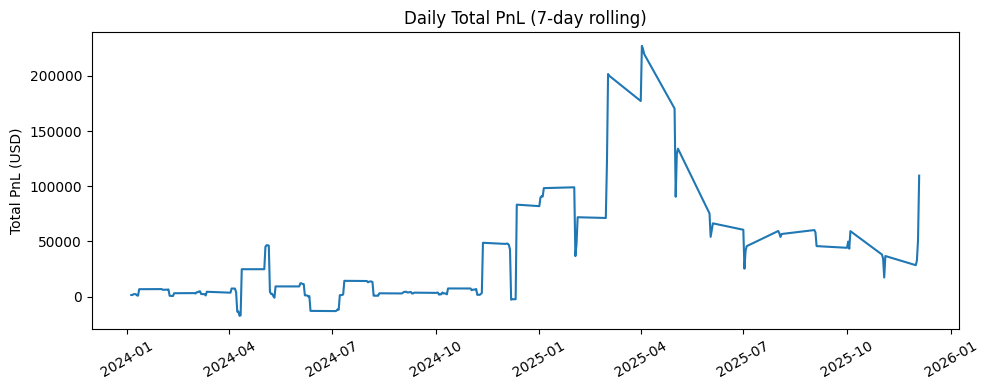

In [251]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(daily_summary['trade_date'], daily_summary['total_pnl'].rolling(7).mean())
plt.title('Daily Total PnL (7-day rolling)')
plt.ylabel('Total PnL (USD)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'daily_total_pnl_7d.png'))
plt.show()


In [252]:
clean_path = os.path.join(CSV_DIR, "trades_cleaned.csv")
df.to_csv(clean_path, index=False)
print("Saved cleaned trades to:", clean_path)


Saved cleaned trades to: /content/drive/MyDrive/ds_pragati_andewadi/csv_files/trades_cleaned.csv


In [253]:
#Working on Sentiment Data

In [254]:
# 1. Load libraries & paths (run if not already)
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

CANDIDATE_NAME = "pragati_andewadi"
PROJECT_DIR = f"/content/drive/MyDrive/ds_{CANDIDATE_NAME}"
CSV_DIR = os.path.join(PROJECT_DIR, "csv_files")
OUT_DIR = os.path.join(PROJECT_DIR, "outputs")
os.makedirs(OUT_DIR, exist_ok=True)

# 2. Load sentiment CSV
sent_path = os.path.join(CSV_DIR, "fear_greed.csv")
df_sent = pd.read_csv(sent_path)

# Quick look
print("Shape:", df_sent.shape)
display(df_sent.head())
print("\nColumns:", df_sent.columns.tolist())
print("\nDtypes:\n", df_sent.dtypes)


Shape: (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



Columns: ['timestamp', 'value', 'classification', 'date']

Dtypes:
 timestamp          int64
value              int64
classification    object
date              object
dtype: object


In [255]:

df_sent.columns = df_sent.columns.str.strip().str.lower().str.replace(' ', '_')
df_sent = df_sent.copy()
df_sent.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [256]:

if 'date' in df_sent.columns:
    df_sent['date'] = pd.to_datetime(df_sent['date'], errors='coerce')
else:

    if 'timestamp' in df_sent.columns:

        sample = str(df_sent['timestamp'].dropna().astype(int).iloc[0])
        unit = 'ms' if len(sample) > 10 else 's'
        df_sent['date'] = pd.to_datetime(df_sent['timestamp'], unit=unit, errors='coerce')
    else:
        raise ValueError("No 'date' or 'timestamp' column found in sentiment file.")


if 'timestamp' in df_sent.columns:
    df_sent.drop(columns=['timestamp'], inplace=True)


print(df_sent[['date','value','classification']].head())
print("\nAny NaT in date column?", df_sent['date'].isna().sum())


        date  value classification
0 2018-02-01     30           Fear
1 2018-02-02     15   Extreme Fear
2 2018-02-03     40           Fear
3 2018-02-04     24   Extreme Fear
4 2018-02-05     11   Extreme Fear

Any NaT in date column? 0


In [257]:
# Clean classification values: strip, lowercase, unify labels
if 'classification' in df_sent.columns:
    df_sent['classification'] = df_sent['classification'].astype(str).str.strip().str.lower()
 "
    df_sent['classification'] = df_sent['classification'].str.replace(' ', '_')


if 'value' in df_sent.columns:
    df_sent['value'] = pd.to_numeric(df_sent['value'], errors='coerce')

df_sent[['date','value','classification']].dropna().head()


,date,value,classification
0,2018-02-01,30,fear
1,2018-02-02,15,extreme_fear
2,2018-02-03,40,fear
3,2018-02-04,24,extreme_fear
4,2018-02-05,11,extreme_fear


In [258]:

df_sent['date_norm'] = df_sent['date'].dt.normalize()


daily_sent = df_sent.groupby('date_norm').agg(
    sentiment_value = ('value', 'mean'),
    sentiment_median = ('value', 'median'),
    sentiment_count = ('value', 'count'),
    classification_mode = ('classification', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
).reset_index().rename(columns={'date_norm':'date'})

daily_sent.head()


,date,sentiment_value,sentiment_median,sentiment_count,classification_mode
0,2018-02-01,30.0,30.0,1,fear
1,2018-02-02,15.0,15.0,1,extreme_fear
2,2018-02-03,40.0,40.0,1,fear
3,2018-02-04,24.0,24.0,1,extreme_fear
4,2018-02-05,11.0,11.0,1,extreme_fear


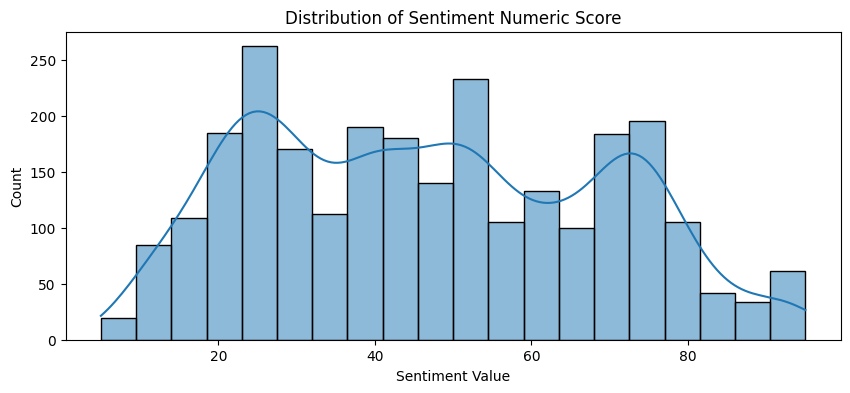

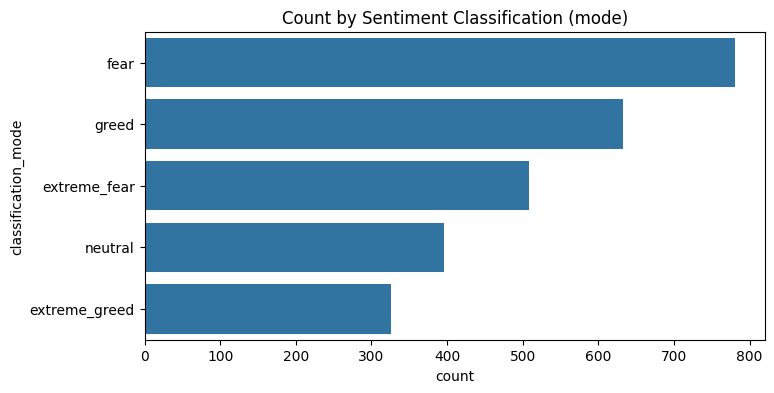

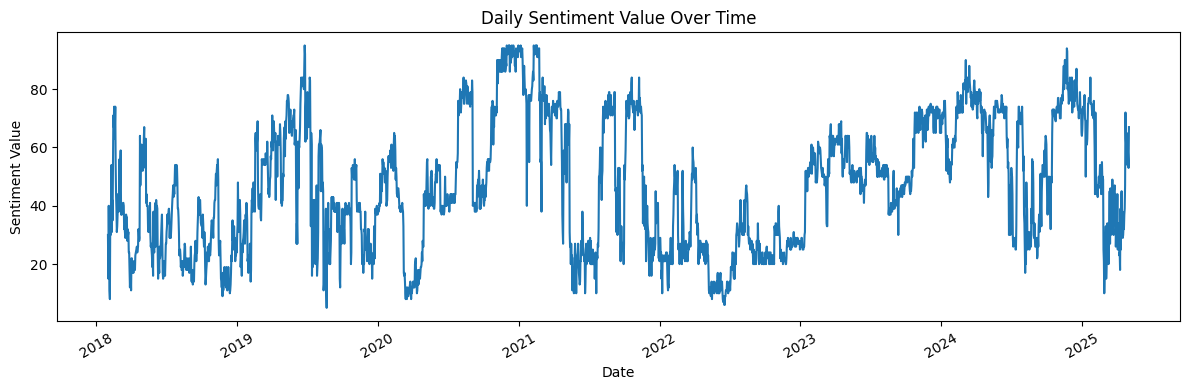

In [259]:
# 1) Distribution of sentiment numeric values
plt.figure(figsize=(10,4))
sns.histplot(daily_sent['sentiment_value'].dropna(), bins=20, kde=True)
plt.title('Distribution of Sentiment Numeric Score')
plt.xlabel('Sentiment Value')
plt.savefig(os.path.join(OUT_DIR, 'sentiment_value_dist.png'), bbox_inches='tight')
plt.show()

# 2) Count of classification categories
plt.figure(figsize=(8,4))
sns.countplot(y='classification_mode', data=daily_sent, order=daily_sent['classification_mode'].value_counts().index)
plt.title('Count by Sentiment Classification (mode)')
plt.savefig(os.path.join(OUT_DIR, 'sentiment_class_count.png'), bbox_inches='tight')
plt.show()

# 3) Time series of sentiment score
plt.figure(figsize=(12,4))
plt.plot(daily_sent['date'], daily_sent['sentiment_value'])
plt.title('Daily Sentiment Value Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Value')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'sentiment_timeseries.png'), bbox_inches='tight')
plt.show()


In [260]:
clean_sent_path = os.path.join(CSV_DIR, "sentiment_daily.csv")
daily_sent.to_csv(clean_sent_path, index=False)
print("Saved cleaned daily sentiment to:", clean_sent_path)


Saved cleaned daily sentiment to: /content/drive/MyDrive/ds_pragati_andewadi/csv_files/sentiment_daily.csv


In [261]:
df_trades = df # Assign the trades DataFrame to df_trades
print(df_trades['trade_date'].dtype)
print(daily_sent['date'].dtype)

datetime64[ns]
datetime64[ns]


In [262]:
# ----------- FIX DTYPE ISSUE -----------
df_trades['trade_date'] = pd.to_datetime(df_trades['trade_date'], errors='coerce')
daily_sent['date'] = pd.to_datetime(daily_sent['date'], errors='coerce')

print("Converted types:")
print(df_trades['trade_date'].dtype)
print(daily_sent['date'].dtype)


Converted types:
datetime64[ns]
datetime64[ns]


In [263]:
df_trades['trade_date'] = pd.to_datetime(df_trades['trade_date'], errors='coerce')


In [264]:

if 'trade_date' not in df_trades.columns:
    if 'timestamp_ist' in df_trades.columns:
        df_trades['timestamp_ist'] = pd.to_datetime(df_trades['timestamp_ist'], errors='coerce')
        df_trades['trade_date'] = df_trades['timestamp_ist'].dt.normalize()
    elif 'timestamp_unix' in df_trades.columns:
        df_trades['timestamp_unix'] = pd.to_datetime(df_trades['timestamp_unix'], errors='coerce')
        df_trades['trade_date'] = df_trades['timestamp_unix'].dt.normalize()


df_trades['trade_date'] = pd.to_datetime(df_trades['trade_date'], errors='coerce')


daily_sent['date'] = pd.to_datetime(daily_sent['date'], errors='coerce')

# Merge
merged = df_trades.merge(daily_sent, left_on='trade_date', right_on='date', how='left')


In [265]:

df_trades['trade_date'] = pd.to_datetime(df_trades['trade_date'])
daily_sent['date'] = pd.to_datetime(daily_sent['date'])


merged = df_trades.merge(daily_sent, left_on='trade_date', right_on='date', how='left')


print(merged.head())
print(merged[['trade_date', 'classification_mode']].sample(10))


                                      account  coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size_tokens  size_usd side       timestamp_ist  start_position direction  \
0       986.87   7872.16  buy 2024-02-12 22:50:00        0.000000       Buy   
1        16.00    127.68  buy 2024-02-12 22:50:00      986.524596       Buy   
2       144.09   1150.63  buy 2024-02-12 22:50:00     1002.518996       Buy   
3       142.98   1142.04  buy 2024-02-12 22:50:00     1146.558564       Buy   
4         8.73     69.75  buy 2024-02-12 22:50:00     1289.488521       Buy   

   closed_pnl  ... trade_date  notional_usd  is_profitable  profit_pct  \
0         0.0  ...

In [266]:
print(daily_sent.columns)


Index(['date', 'sentiment_value', 'sentiment_median', 'sentiment_count',
       'classification_mode'],
      dtype='object')


In [267]:
# Merge the datasets
merged = df_trades.merge(
    daily_sent[['date', 'classification_mode']],
    left_on='trade_date',
    right_on='date',
    how='left'
)

# Inspect results
print(merged.head())
print(merged[['trade_date', 'classification_mode']].sample(5))
print(merged['classification_mode'].value_counts(dropna=False))


                                      account  coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size_tokens  size_usd side       timestamp_ist  start_position direction  \
0       986.87   7872.16  buy 2024-02-12 22:50:00        0.000000       Buy   
1        16.00    127.68  buy 2024-02-12 22:50:00      986.524596       Buy   
2       144.09   1150.63  buy 2024-02-12 22:50:00     1002.518996       Buy   
3       142.98   1142.04  buy 2024-02-12 22:50:00     1146.558564       Buy   
4         8.73     69.75  buy 2024-02-12 22:50:00     1289.488521       Buy   

   closed_pnl  ...      trade_id     timestamp      timestamp_unix  \
0         0.0  ...  8.

In [268]:
df.head()

,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,crossed,fee,trade_id,timestamp,timestamp_unix,trade_date,notional_usd,is_profitable,profit_pct,direction_norm
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,2024-02-12 22:50:00,0.000000,Buy,0.0,...,True,0.345404,8.950000e+14,1.730000e+12,2024-10-27 03:33:20,2024-02-12,7872.16,False,0.0,NaN
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,2024-02-12 22:50:00,986.524596,Buy,0.0,...,True,0.005600,4.430000e+14,1.730000e+12,2024-10-27 03:33:20,2024-02-12,127.68,False,0.0,NaN
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,2024-02-12 22:50:00,1002.518996,Buy,0.0,...,True,0.050431,6.600000e+14,1.730000e+12,2024-10-27 03:33:20,2024-02-12,1150.63,False,0.0,NaN
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,buy,2024-02-12 22:50:00,1146.558564,Buy,0.0,...,True,0.050043,1.080000e+15,1.730000e+12,2024-10-27 03:33:20,2024-02-12,1142.04,False,0.0,NaN
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,buy,2024-02-12 22:50:00,1289.488521,Buy,0.0,...,True,0.003055,1.050000e+15,1.730000e+12,2024-10-27 03:33:20,2024-02-12,69.75,False,0.0,NaN


In [269]:
print(df.dtypes)

account                     object
coin                        object
execution_price            float64
size_tokens                float64
size_usd                   float64
side                        object
timestamp_ist       datetime64[ns]
start_position             float64
direction                   object
closed_pnl                 float64
transaction_hash            object
order_id                     int64
crossed                       bool
fee                        float64
trade_id                   float64
timestamp                  float64
timestamp_unix      datetime64[ns]
trade_date          datetime64[ns]
notional_usd               float64
is_profitable                 bool
profit_pct                 float64
direction_norm             float64
dtype: object


In [270]:

df = merged


cols_check = ['account','coin','side','direction','direction_norm','order_id','trade_id','timestamp']
for c in cols_check:
    if c in df.columns:
        print(c, "unique:", df[c].nunique(), "nulls:", df[c].isna().sum())


cat_cols = [c for c in ['account','coin','side','direction'] if c in df.columns]
for c in cat_cols:
    df[c] = df[c].astype('category')


if 'direction_norm' in df.columns:

    print("direction_norm unique values:", df['direction_norm'].unique()[:20])

    if df['direction_norm'].isna().any():
        df['direction_norm'] = df['direction_norm'].astype('Int8')
    else:
        df['direction_norm'] = df['direction_norm'].astype('int8')


if 'trade_id' in df.columns:
    if df['trade_id'].notna().all() and (df['trade_id'] % 1 == 0).all():
        df['trade_id'] = df['trade_id'].astype('Int64')
    else:

        pass


if 'order_id' in df.columns:
    max_order = df['order_id'].max()
    if max_order < 2**31:
        df['order_id'] = df['order_id'].astype('int32')


num_cols = df.select_dtypes(include=['float64']).columns.tolist()
print("Numeric float64 columns to consider downcast:", num_cols)
for c in num_cols:

    if c not in ['timestamp_unix','timestamp']:
        df[c] = pd.to_numeric(df[c], downcast='float')

if 'timestamp' in df.columns:

    print("timestamp sample:", df['timestamp'].dropna().astype(str).iloc[:5])



for c in ['timestamp_ist','timestamp_unix','trade_date']:
    if c in df.columns:
        print(c, df[c].dtype)

# Final dtypes printout
print(df.dtypes)

# Save a cleaned copy
df.to_csv(os.path.join(CSV_DIR, 'trades_with_sentiment_dtypes_cleaned.csv'), index=False)
print("Saved cleaned file with optimized dtypes.")


account unique: 32 nulls: 0
coin unique: 246 nulls: 0
side unique: 2 nulls: 0
direction unique: 12 nulls: 0
direction_norm unique: 0 nulls: 211224
order_id unique: 50555 nulls: 0
trade_id unique: 2810 nulls: 0
timestamp unique: 7 nulls: 0
direction_norm unique values: [nan]
Numeric float64 columns to consider downcast: ['execution_price', 'size_tokens', 'size_usd', 'start_position', 'closed_pnl', 'fee', 'timestamp', 'notional_usd', 'profit_pct']
timestamp sample: 0    1730000000000.0
1    1730000000000.0
2    1730000000000.0
3    1730000000000.0
4    1730000000000.0
Name: timestamp, dtype: object
timestamp_ist datetime64[ns]
timestamp_unix datetime64[ns]
trade_date datetime64[ns]
account                      category
coin                         category
execution_price               float64
size_tokens                   float64
size_usd                      float64
side                         category
timestamp_ist          datetime64[ns]
start_position                float64
directi

In [271]:
# Quick check
#print("merged rows:", len(merged))
#print("columns:", merged.columns.tolist())
#print(merged[['trade_date','closed_pnl','notional_usd','sentiment_score' if 'sentiment_score' in merged.columns else 'sentiment_value','sentiment_label' if 'sentiment_label' in merged.columns else 'classification_mode']].head())


In [272]:

merged.columns = merged.columns.str.strip().str.lower().str.replace(' ', '_')


if 'classification_mode' in merged.columns and 'sentiment_label' not in merged.columns:
    merged = merged.rename(columns={'classification_mode':'sentiment_label'})
if 'sentiment_value' in merged.columns and 'sentiment_score' not in merged.columns:
    merged = merged.rename(columns={'sentiment_value':'sentiment_score'})

agg = merged.groupby('sentiment_label').agg(
    trades_count = ('order_id','count'),
    total_pnl = ('closed_pnl','sum'),
    avg_pnl_per_trade = ('closed_pnl','mean'),
    median_pnl = ('closed_pnl','median'),
    std_pnl = ('closed_pnl','std'),
    win_rate = ('is_profitable','mean'),
    avg_profit_pct = ('profit_pct','mean'),
    avg_notional = ('notional_usd','mean'),
    median_notional = ('notional_usd','median'),
    #avg_leverage = ('leverage','mean')
).reset_index()


display(agg.style.format({
    'trades_count':'{:,}',
    'total_pnl':'{:.2f}',
    'avg_pnl_per_trade':'{:.2f}',
    'win_rate':'{:.2%}',
    'avg_profit_pct':'{:.2%}',
    'avg_notional':'{:.2f}'
}))
agg.to_csv(os.path.join(OUT_DIR,'summary_by_sentiment.csv'), index=False)
print("Saved:", os.path.join(OUT_DIR,'summary_by_sentiment.csv'))


,sentiment_label,trades_count,total_pnl,avg_pnl_per_trade,median_pnl,std_pnl,win_rate,avg_profit_pct,avg_notional,median_notional
0,extreme_fear,"2,326",4399.94,1.89,0.000000,76.727713,29.28%,0.32%,4118.76,599.120000
1,extreme_greed,"5,621",1156893.68,205.82,0.960480,1861.557119,55.33%,13.49%,3242.09,365.000000
2,fear,"13,869",1779225.58,128.29,0.000000,1342.348497,38.18%,2.98%,5744.78,703.880000
3,greed,"11,292",609632.53,53.99,0.000000,1399.468182,43.57%,3.05%,5051.88,675.080000
4,neutral,"2,756",74656.74,27.09,0.000000,142.945889,49.49%,2.38%,4332.20,411.810000


Saved: /content/drive/MyDrive/ds_pragati_andewadi/outputs/summary_by_sentiment.csv


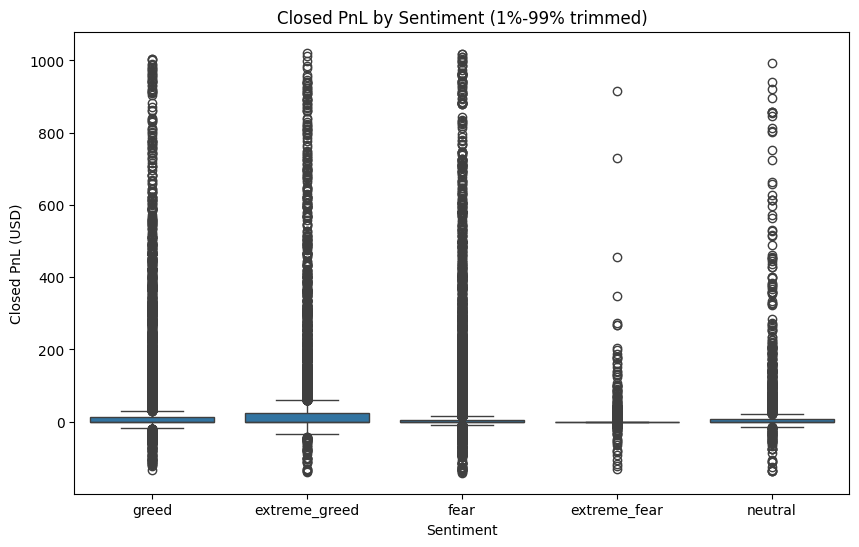

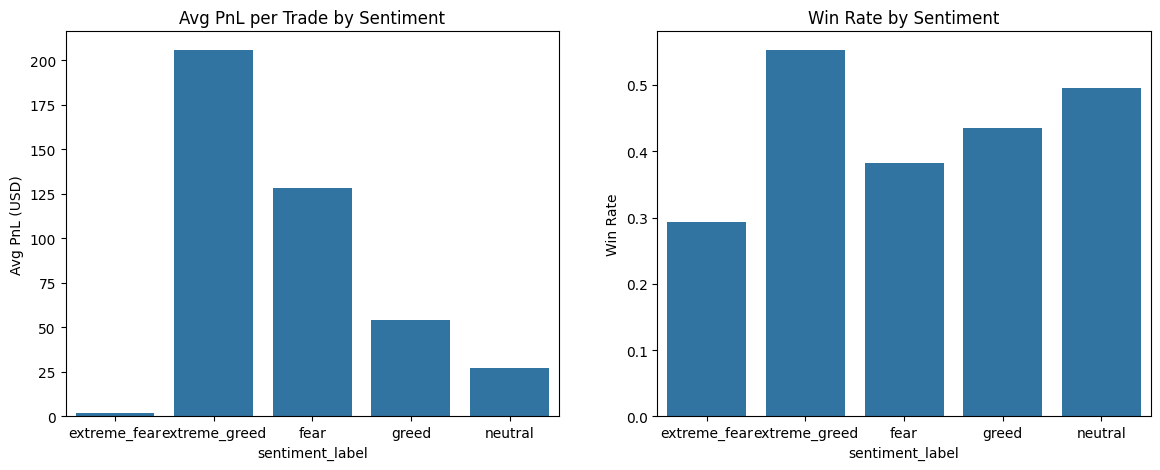

In [273]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot of closed_pnl by sentiment (trim tails to visualize bulk)
low, high = merged['closed_pnl'].quantile(0.01), merged['closed_pnl'].quantile(0.99)
plt.figure(figsize=(10,6))
sns.boxplot(x='sentiment_label', y='closed_pnl', data=merged[merged['closed_pnl'].between(low, high)])
plt.title('Closed PnL by Sentiment (1%-99% trimmed)')
plt.ylabel('Closed PnL (USD)')
plt.xlabel('Sentiment')
plt.savefig(os.path.join(OUT_DIR,'boxplot_pnl_by_sentiment.png'), bbox_inches='tight')
plt.show()

# Bar charts: avg pnl per trade and win rate
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.barplot(x='sentiment_label', y='avg_pnl_per_trade', data=agg, ax=ax[0])
ax[0].set_title('Avg PnL per Trade by Sentiment')
ax[0].set_ylabel('Avg PnL (USD)')
sns.barplot(x='sentiment_label', y='win_rate', data=agg, ax=ax[1])
ax[1].set_title('Win Rate by Sentiment')
ax[1].set_ylabel('Win Rate')
plt.savefig(os.path.join(OUT_DIR,'bar_pnl_winrate_by_sentiment.png'), bbox_inches='tight')
plt.show()


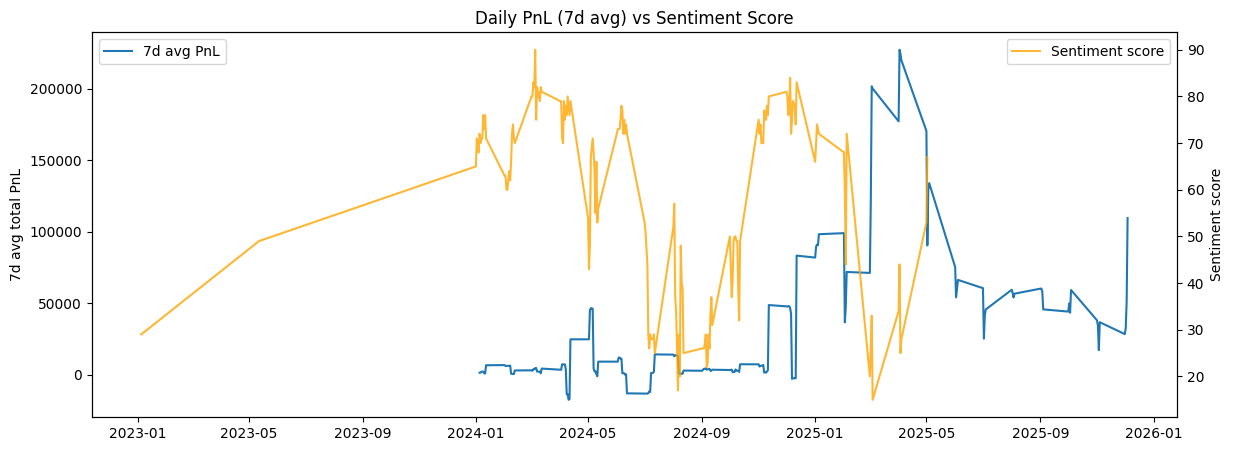

In [274]:
# Daily aggregates
daily_pnl = merged.groupby('trade_date').agg(daily_total_pnl=('closed_pnl','sum')).reset_index()
# prepare sentiment series (use daily_sent if available)
if 'daily_sent' in globals():
    ss = daily_sent.rename(columns={'date':'trade_date'})
    if 'sentiment_value' in ss.columns and 'sentiment_score' not in ss.columns:
        ss = ss.rename(columns={'sentiment_value':'sentiment_score'})
else:
    ss = merged.groupby('trade_date').agg(sentiment_score=('sentiment_score','mean')).reset_index()

ts = daily_pnl.merge(ss[['trade_date','sentiment_score']], on='trade_date', how='left').sort_values('trade_date')

fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(ts['trade_date'], ts['daily_total_pnl'].rolling(7).mean(), label='7d avg PnL')
ax1.set_ylabel('7d avg total PnL')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(ts['trade_date'], ts['sentiment_score'], color='orange', alpha=0.8, label='Sentiment score')
ax2.set_ylabel('Sentiment score')
ax2.legend(loc='upper right')
plt.title('Daily PnL (7d avg) vs Sentiment Score')
plt.savefig(os.path.join(OUT_DIR,'ts_pnl_vs_sentiment.png'), bbox_inches='tight')
plt.show()


In [275]:
from scipy.stats import mannwhitneyu

g_fear = merged[merged['sentiment_label'].str.contains('fear', case=False, na=False)]['closed_pnl']
g_greed = merged[merged['sentiment_label'].str.contains('greed', case=False, na=False)]['closed_pnl']

print("N fear:", len(g_fear), "N greed:", len(g_greed))
stat, p = mannwhitneyu(g_fear, g_greed, alternative='two-sided')
print("Mann-Whitney U stat:", stat, "p-value:", p)

def cliffs_delta(a,b):
    import numpy as np
    n1,n2 = len(a),len(b)
    pairs = 0
    gt = 0
    for x in a:
        for y in b:
            if x>y: gt += 1
            elif x<y: gt -= 1
            pairs += 1
    return gt/pairs
print("Cliff's delta (approx):", cliffs_delta(g_fear.values, g_greed.values))


N fear: 16195 N greed: 16913
Mann-Whitney U stat: 122776380.0 p-value: 1.384301904177245e-68
Cliff's delta (approx): -0.10351460492646684


In [276]:
acct_sent = merged.groupby(['account','sentiment_label']).agg(
    trades=('order_id','count'),
    total_pnl=('closed_pnl','sum'),
    mean_pnl=('closed_pnl','mean'),
    win_rate=('is_profitable','mean'),
    avg_notional=('notional_usd','mean')
).reset_index()

top_greed = acct_sent[acct_sent['sentiment_label'].str.contains('greed', case=False, na=False)].sort_values('total_pnl', ascending=False).head(15)
top_fear = acct_sent[acct_sent['sentiment_label'].str.contains('fear', case=False, na=False)].sort_values('total_pnl', ascending=False).head(15)

top_greed.to_csv(os.path.join(OUT_DIR,'top_accounts_greed.csv'), index=False)
top_fear.to_csv(os.path.join(OUT_DIR,'top_accounts_fear.csv'), index=False)
display(top_greed, top_fear)
print("Saved top account lists to outputs/")


/tmp/ipython-input-2193054397.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acct_sent = merged.groupby(['account','sentiment_label']).agg(


,account,sentiment_label,trades,total_pnl,mean_pnl,win_rate,avg_notional
136,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,extreme_greed,962,997871.478418,1037.288439,0.612266,3730.749148
138,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,greed,2032,332705.773842,163.733156,0.280020,5748.129995
148,0xbaaaf6571ab7d571043ff1e313a9609a10637864,greed,744,188116.840712,252.845216,1.000000,3799.586747
156,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,extreme_greed,1571,155490.182605,98.975291,0.870146,2127.841553
88,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,greed,936,68045.186468,72.697849,0.872863,4269.641613
68,0x513b8629fe877bb581bf244e326a047b249c4ff1,greed,342,60544.304874,177.030131,0.690058,22374.739152
123,0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0,greed,63,34709.852428,550.950039,0.777778,1148.431429
63,0x4f93fead39b70a1824f981a54d4e55b278e9f760,greed,663,28159.421489,42.472732,0.242836,14443.715988
21,0x2c229d22b100a7beb69122eed721cee9b24011dd,extreme_greed,191,23897.024855,125.115313,0.481675,3799.691623
18,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,greed,1035,22639.472053,21.873886,0.433816,451.664251


,account,sentiment_label,trades,total_pnl,mean_pnl,win_rate,avg_notional
2,0x083384f897ee0f19899168e3b1bec365f52a9012,fear,2011,1.010607e+06,502.539343,0.437096,15304.158518
82,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,fear,198,1.972949e+05,996.439069,0.565657,2936.838081
152,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,fear,441,1.711983e+05,388.204726,0.464853,7665.210816
137,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,fear,1525,1.481471e+05,97.145610,0.314098,3171.631823
62,0x4f93fead39b70a1824f981a54d4e55b278e9f760,fear,502,6.893832e+04,137.327338,0.458167,17343.383227
142,0xb899e522b5715391ae1d4f137653e7906c5e2115,fear,316,3.990974e+04,126.296648,0.481013,21077.525759
87,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,fear,779,3.547117e+04,45.534239,0.768935,3100.178703
97,0x8170715b3b381dffb7062c0298972d4727a0a63b,fear,258,2.551553e+04,98.897421,0.449612,624.333411
157,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,fear,2288,1.979066e+04,8.649766,0.364510,1719.162417
17,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,fear,879,1.678161e+04,19.091706,0.515358,469.169295


Saved top account lists to outputs/


In [277]:
merged['sentiment_label']


,sentiment_label
0,greed
1,greed
2,greed
3,greed
4,greed
...,...
211219,NaN
211220,NaN
211221,NaN
211222,NaN


In [278]:
# Create sentiment label categories
daily_sent['sentiment_label'] = pd.cut(
    daily_sent['sentiment_value'],
    bins=[-1.1, -0.2, 0.2, 1.1],
    labels=['negative', 'neutral', 'positive']
)


In [279]:
daily_sent.head()


,date,sentiment_value,sentiment_median,sentiment_count,classification_mode,sentiment_label
0,2018-02-01,30.0,30.0,1,fear,NaN
1,2018-02-02,15.0,15.0,1,extreme_fear,NaN
2,2018-02-03,40.0,40.0,1,fear,NaN
3,2018-02-04,24.0,24.0,1,extreme_fear,NaN
4,2018-02-05,11.0,11.0,1,extreme_fear,NaN


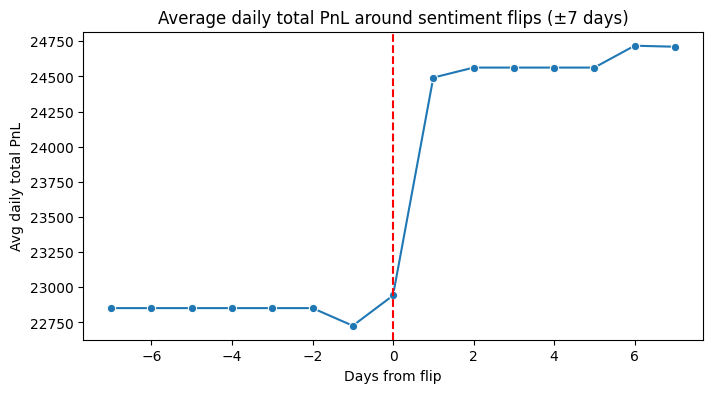

Saved event study results.


In [280]:

s = daily_sent.sort_values('date').reset_index(drop=True).rename(columns={'date':'trade_date'})
s['prev'] = s['sentiment_label'].shift(1)
flips = s[s['sentiment_label'] != s['prev']]['trade_date'].tolist()
len(flips), flips[:5]

# Build event windows
window = 7
frames = []
for d in flips:
    start = d - pd.Timedelta(days=window)
    end = d + pd.Timedelta(days=window)
    sub = ts.set_index('trade_date').loc[start:end].reset_index()
    sub['flip_date'] = d
    sub['day_offset'] = (sub['trade_date'] - d).dt.days
    frames.append(sub[['flip_date','day_offset','daily_total_pnl']])
event_df = pd.concat(frames, ignore_index=True)
event_avg = event_df.groupby('day_offset')['daily_total_pnl'].mean().reset_index()

# Plot event study
plt.figure(figsize=(8,4))
sns.lineplot(x='day_offset', y='daily_total_pnl', data=event_avg, marker='o')
plt.axvline(0, color='red', linestyle='--')
plt.title('Average daily total PnL around sentiment flips (±7 days)')
plt.ylabel('Avg daily total PnL')
plt.xlabel('Days from flip')
plt.savefig(os.path.join(OUT_DIR,'event_study_sentiment_flip.png'), bbox_inches='tight')
plt.show()

event_avg.to_csv(os.path.join(OUT_DIR,'event_study_avg_pnl.csv'), index=False)
print("Saved event study results.")


In [281]:
merged.to_csv(os.path.join(CSV_DIR,'trades_with_sentiment_final.csv'), index=False)
print("Saved merged dataset:", os.path.join(CSV_DIR,'trades_with_sentiment_final.csv'))


Saved merged dataset: /content/drive/MyDrive/ds_pragati_andewadi/csv_files/trades_with_sentiment_final.csv


In [282]:
performance = merged.groupby('sentiment_label').agg({
    'closed_pnl': ['mean', 'sum', 'count'],
    'profit_pct': 'mean',
    'is_profitable': 'mean'
})

performance


closed_pnl                      profit_pct is_profitable
                       mean           sum  count       mean          mean
sentiment_label                                                          
extreme_fear       1.891632  4.399937e+03   2326   0.003188      0.292777
extreme_greed    205.816345  1.156894e+06   5621   0.134938      0.553282
fear             128.287950  1.779226e+06  13869   0.029800      0.381787
greed             53.988003  6.096325e+05  11292   0.030454      0.435707
neutral           27.088803  7.465674e+04   2756   0.023814      0.494920

In [283]:
performance = merged.groupby('sentiment_label').agg({
    'closed_pnl': ['mean', 'sum', 'count'],
    'profit_pct': 'mean',
    'is_profitable': 'mean'
})

performance


closed_pnl                      profit_pct is_profitable
                       mean           sum  count       mean          mean
sentiment_label                                                          
extreme_fear       1.891632  4.399937e+03   2326   0.003188      0.292777
extreme_greed    205.816345  1.156894e+06   5621   0.134938      0.553282
fear             128.287950  1.779226e+06  13869   0.029800      0.381787
greed             53.988003  6.096325e+05  11292   0.030454      0.435707
neutral           27.088803  7.465674e+04   2756   0.023814      0.494920

In [284]:
print(daily_sent.columns)
daily_sent.head()


Index(['date', 'sentiment_value', 'sentiment_median', 'sentiment_count',
       'classification_mode', 'sentiment_label'],
      dtype='object')


,date,sentiment_value,sentiment_median,sentiment_count,classification_mode,sentiment_label
0,2018-02-01,30.0,30.0,1,fear,NaN
1,2018-02-02,15.0,15.0,1,extreme_fear,NaN
2,2018-02-03,40.0,40.0,1,fear,NaN
3,2018-02-04,24.0,24.0,1,extreme_fear,NaN
4,2018-02-05,11.0,11.0,1,extreme_fear,NaN


In [285]:
print(merged.columns)
merged.head()


Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp', 'timestamp_unix', 'trade_date', 'notional_usd',
       'is_profitable', 'profit_pct', 'direction_norm', 'date',
       'sentiment_label'],
      dtype='object')


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,trade_id,timestamp,timestamp_unix,trade_date,notional_usd,is_profitable,profit_pct,direction_norm,date,sentiment_label
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,2024-02-12 22:50:00,0.000000,Buy,0.0,...,895000000000000,1.730000e+12,2024-10-27 03:33:20,2024-02-12,7872.16,False,0.0,<NA>,2024-02-12,greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,2024-02-12 22:50:00,986.524596,Buy,0.0,...,443000000000000,1.730000e+12,2024-10-27 03:33:20,2024-02-12,127.68,False,0.0,<NA>,2024-02-12,greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,2024-02-12 22:50:00,1002.518996,Buy,0.0,...,660000000000000,1.730000e+12,2024-10-27 03:33:20,2024-02-12,1150.63,False,0.0,<NA>,2024-02-12,greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,buy,2024-02-12 22:50:00,1146.558564,Buy,0.0,...,1080000000000000,1.730000e+12,2024-10-27 03:33:20,2024-02-12,1142.04,False,0.0,<NA>,2024-02-12,greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,buy,2024-02-12 22:50:00,1289.488521,Buy,0.0,...,1050000000000000,1.730000e+12,2024-10-27 03:33:20,2024-02-12,69.75,False,0.0,<NA>,2024-02-12,greed


In [286]:
# Force correct dtypes
df_trades['trade_date'] = pd.to_datetime(df_trades['trade_date'], errors='coerce')
daily_sent['date'] = pd.to_datetime(daily_sent['date'], errors='coerce')

# Merge again with full sentiment dataset
merged = df_trades.merge(
    daily_sent,
    left_on='trade_date',
    right_on='date',
    how='left'
)

print("Merged shape:", merged.shape)
print(merged.columns)
merged.head()


Merged shape: (211224, 28)
Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp', 'timestamp_unix', 'trade_date', 'notional_usd',
       'is_profitable', 'profit_pct', 'direction_norm', 'date',
       'sentiment_value', 'sentiment_median', 'sentiment_count',
       'classification_mode', 'sentiment_label'],
      dtype='object')


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,notional_usd,is_profitable,profit_pct,direction_norm,date,sentiment_value,sentiment_median,sentiment_count,classification_mode,sentiment_label
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,2024-02-12 22:50:00,0.000000,Buy,0.0,...,7872.16,False,0.0,NaN,2024-02-12,70.0,70.0,1.0,greed,NaN
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,2024-02-12 22:50:00,986.524596,Buy,0.0,...,127.68,False,0.0,NaN,2024-02-12,70.0,70.0,1.0,greed,NaN
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,2024-02-12 22:50:00,1002.518996,Buy,0.0,...,1150.63,False,0.0,NaN,2024-02-12,70.0,70.0,1.0,greed,NaN
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,buy,2024-02-12 22:50:00,1146.558564,Buy,0.0,...,1142.04,False,0.0,NaN,2024-02-12,70.0,70.0,1.0,greed,NaN
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,buy,2024-02-12 22:50:00,1289.488521,Buy,0.0,...,69.75,False,0.0,NaN,2024-02-12,70.0,70.0,1.0,greed,NaN


In [287]:
bins = [-999, 20, 40, 60, 80, 999]
labels = ['extreme_fear','fear','neutral','greed','extreme_greed']

merged['sentiment_strength'] = pd.cut(
    merged['sentiment_value'],
    bins=bins,
    labels=labels
)

print(merged['sentiment_strength'].value_counts(dropna=False))


sentiment_strength
NaN              175360
greed             12539
fear              10721
neutral            7794
extreme_greed      2516
extreme_fear       2294
Name: count, dtype: int64


In [288]:

merged['side'] = merged['side'].astype(str).str.lower().str.strip()
merged['direction'] = merged.get('direction', merged.get('side'))

# Group by sentiment_strength and side
dir_agg = merged.groupby(['sentiment_strength','side']).agg(
    trades_count = ('order_id','count'),
    total_pnl = ('closed_pnl','sum'),
    avg_pnl = ('closed_pnl','mean'),
    win_rate = ('is_profitable','mean'),
    avg_notional = ('notional_usd','mean')
).reset_index()

display(dir_agg.sort_values(['sentiment_strength','trades_count'], ascending=[True, False]))
dir_agg.to_csv(os.path.join(OUT_DIR,'direction_by_sentiment_strength.csv'), index=False)
print("Saved direction_by_sentiment_strength.csv")


/tmp/ipython-input-1378123916.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dir_agg = merged.groupby(['sentiment_strength','side']).agg(


,sentiment_strength,side,trades_count,total_pnl,avg_pnl,win_rate,avg_notional
0,extreme_fear,buy,1151,-3.794627e+03,-3.296809,0.063423,4705.048549
1,extreme_fear,sell,1143,7.545579e+03,6.601557,0.518810,3621.681969
2,fear,buy,5834,1.132500e+06,194.120681,0.348817,5380.334892
3,fear,sell,4887,1.584093e+05,32.414430,0.463065,5115.507180
5,neutral,sell,4219,2.298569e+05,54.481376,0.484475,5256.808884
4,neutral,buy,3575,5.700793e+05,159.462745,0.289510,5683.639726
7,greed,sell,7251,9.521403e+05,131.311587,0.549304,4900.678051
6,greed,buy,5288,-5.810769e+04,-10.988595,0.331694,4784.678336
9,extreme_greed,sell,1801,6.306229e+05,350.151514,0.825097,2174.042926
8,extreme_greed,buy,715,5.556407e+03,7.771199,0.145455,4575.065734


Saved direction_by_sentiment_strength.csv


Spearman corr (sent_prev1 vs daily_total_pnl): -0.05127964042705352


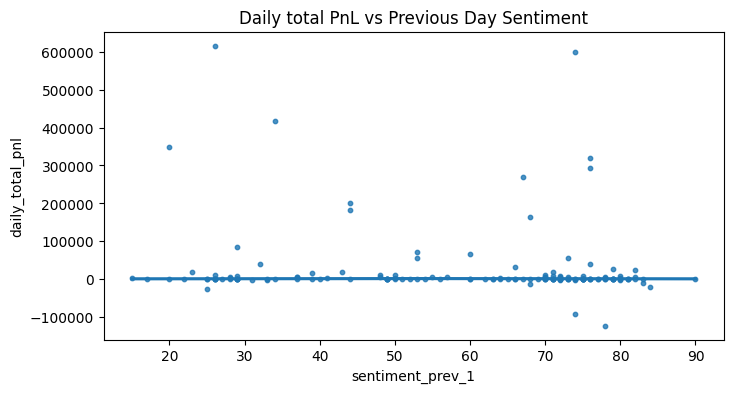

LR coef: [-542.38423188] intercept: 56702.03033310813 R2: 0.013531749116972636


In [289]:

daily = merged.groupby('trade_date').agg(
    daily_total_pnl=('closed_pnl','sum'),
    daily_avg_pnl=('closed_pnl','mean'),
    daily_win_rate=('is_profitable','mean'),
    daily_trades=('order_id','count'),
    sentiment_score=('sentiment_value','mean')
).reset_index().sort_values('trade_date')


daily['sentiment_prev_1'] = daily['sentiment_score'].shift(1)
daily['sentiment_prev_2'] = daily['sentiment_score'].shift(2)

# Correlation between lagged sentiment and next day pnl
print("Spearman corr (sent_prev1 vs daily_total_pnl):", daily[['sentiment_prev_1','daily_total_pnl']].corr(method='spearman').iloc[0,1])

# Visualize scatter
plt.figure(figsize=(8,4))
sns.regplot(x='sentiment_prev_1', y='daily_total_pnl', data=daily, scatter_kws={'s':10}, lowess=True)
plt.title('Daily total PnL vs Previous Day Sentiment')
plt.savefig(os.path.join(OUT_DIR,'lagged_sentiment_vs_pnl.png'), bbox_inches='tight')
plt.show()


from sklearn.linear_model import LinearRegression
lr = LinearRegression()
valid = daily.dropna(subset=['sentiment_prev_1','daily_total_pnl'])
X = valid[['sentiment_prev_1']]
y = valid['daily_total_pnl']
lr.fit(X,y)
print("LR coef:", lr.coef_, "intercept:", lr.intercept_, "R2:", lr.score(X,y))


In [290]:
# Ensure sentiment_value exists
print("Sentiment value exists?:", 'sentiment_value' in merged.columns)

bins = [-999, 20, 40, 60, 80, 999]
labels = ['extreme_fear', 'fear', 'neutral', 'greed', 'extreme_greed']

merged['sentiment_strength'] = pd.cut(
    merged['sentiment_value'],
    bins=bins,
    labels=labels
)

print(merged['sentiment_strength'].value_counts(dropna=False))


Sentiment value exists?: True
sentiment_strength
NaN              175360
greed             12539
fear              10721
neutral            7794
extreme_greed      2516
extreme_fear       2294
Name: count, dtype: int64


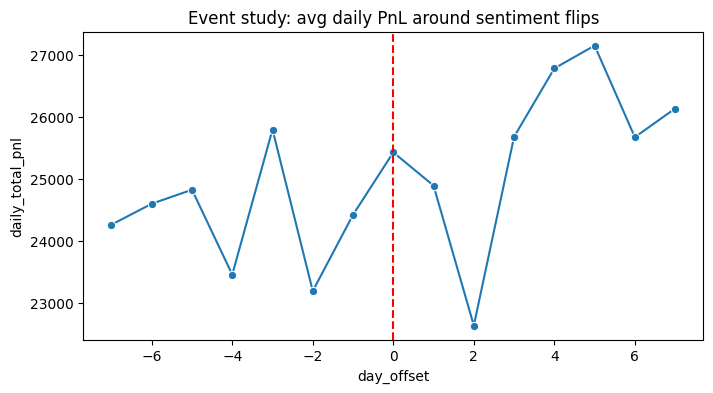

Saved event study results


In [291]:

s = daily_sent.sort_values('date').rename(columns={'date':'trade_date'})
s['prev'] = s['sentiment_value'].shift(1)
flips = s[s['sentiment_value'] != s['prev']]['trade_date']
flips = flips.dropna().tolist()

# Build +/- 7 day windows and compute average daily_total_pnl relative to flip
window = 7
frames = []
ts = daily.copy().rename(columns={'trade_date':'date'})
for d in flips:
    start = d - pd.Timedelta(days=window)
    end = d + pd.Timedelta(days=window)
    temp = ts[(ts['date'] >= start) & (ts['date'] <= end)].copy()
    temp['flip_date'] = d
    temp['day_offset'] = (temp['date'] - d).dt.days
    frames.append(temp[['flip_date','day_offset','daily_total_pnl']])

event_df = pd.concat(frames) if frames else pd.DataFrame()
event_avg = event_df.groupby('day_offset')['daily_total_pnl'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.lineplot(x='day_offset', y='daily_total_pnl', data=event_avg, marker='o')
plt.axvline(0,color='red',linestyle='--'); plt.title('Event study: avg daily PnL around sentiment flips')
plt.savefig(os.path.join(OUT_DIR,'event_study_flips.png'), bbox_inches='tight')
plt.show()

event_avg.to_csv(os.path.join(OUT_DIR,'event_study_flips_avg_pnl.csv'), index=False)
print("Saved event study results")

In [292]:
print(merged.columns.tolist())


['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'timestamp_unix', 'trade_date', 'notional_usd', 'is_profitable', 'profit_pct', 'direction_norm', 'date', 'sentiment_value', 'sentiment_median', 'sentiment_count', 'classification_mode', 'sentiment_label', 'sentiment_strength']


In [293]:
merged['sentiment_value'].head()


,sentiment_value
0,70.0
1,70.0
2,70.0
3,70.0
4,70.0


In [294]:
merged.groupby('sentiment_strength')['profit_pct'].mean()


/tmp/ipython-input-4123551591.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.groupby('sentiment_strength')['profit_pct'].mean()


,profit_pct
sentiment_strength,
extreme_fear,0.001713
fear,0.033590
neutral,0.022412
greed,0.044526
extreme_greed,0.195417


In [295]:
# Ensure sentiment_value exists
print("Sentiment value exists?:", 'sentiment_value' in merged.columns)


bins = [-999, 20, 40, 60, 80, 999]
labels = ['extreme_fear', 'fear', 'neutral', 'greed', 'extreme_greed']

merged['sentiment_strength'] = pd.cut(
    merged['sentiment_value'],
    bins=bins,
    labels=labels
)

print(merged['sentiment_strength'].value_counts(dropna=False))


Sentiment value exists?: True
sentiment_strength
NaN              175360
greed             12539
fear              10721
neutral            7794
extreme_greed      2516
extreme_fear       2294
Name: count, dtype: int64


Total flips found: 577
Saved event_study_summary.csv


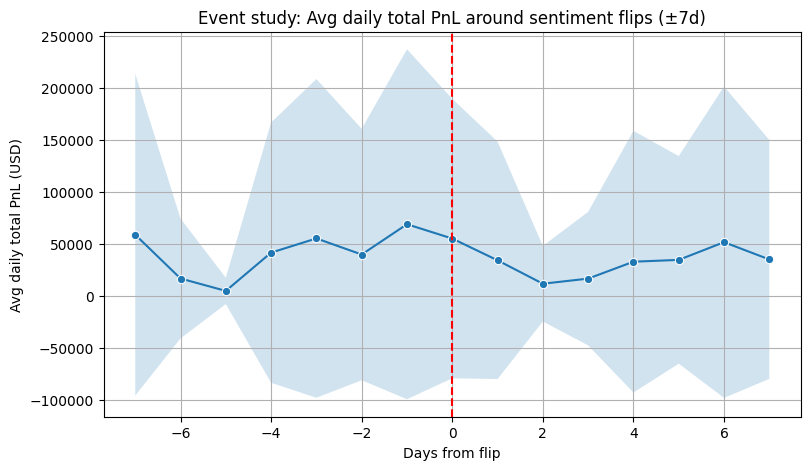

Pre vs Post t-test (unpaired): stat=-2.0224, p=0.0479 (n flips=29)
Saved paired pre/post per-flip summary.


In [296]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


MERGED = merged
DAILY_SENT = daily_sent
CSV_OUT = CSV_DIR
OUT = OUT_DIR


daily_pnl = MERGED.groupby('trade_date').agg(daily_total_pnl=('closed_pnl','sum')).reset_index().sort_values('trade_date')
daily_pnl['trade_date'] = pd.to_datetime(daily_pnl['trade_date'])


DAILY_SENT['date'] = pd.to_datetime(DAILY_SENT['date']).dt.normalize()
if 'sentiment_strength' not in DAILY_SENT.columns:

    if 'sentiment_value' in DAILY_SENT.columns:
        bins = [-999, 20, 40, 60, 80, 999]
        labels = ['extreme_fear','fear','neutral','greed','extreme_greed']
        DAILY_SENT['sentiment_strength'] = pd.cut(DAILY_SENT['sentiment_value'], bins=bins, labels=labels)
    else:
        DAILY_SENT['sentiment_strength'] = DAILY_SENT.get('classification_mode', DAILY_SENT.get('classification','unknown'))


s = DAILY_SENT.sort_values('date').reset_index(drop=True).rename(columns={'date':'trade_date'})
s['prev'] = s['sentiment_strength'].shift(1)
flip_mask = (s['sentiment_strength'] != s['prev']) & s['prev'].notna()
flips = s.loc[flip_mask, 'trade_date'].tolist()
print("Total flips found:", len(flips))
if len(flips) == 0:
    print("No flips detected — consider using different bin boundaries or using 'classification_mode' instead.")

window = 7
frames = []
ts = daily_pnl.rename(columns={'trade_date':'date'}).set_index('date')
for d in flips:
    start = (d - pd.Timedelta(days=window)).normalize()
    end = (d + pd.Timedelta(days=window)).normalize()

    sub = ts.loc[start:end].reset_index()
    if sub.empty:
        continue
    sub['flip_date'] = pd.to_datetime(d)
    sub['day_offset'] = (sub['date'] - pd.to_datetime(d)).dt.days
    frames.append(sub[['flip_date','day_offset','daily_total_pnl']])

if not frames:
    raise ValueError("No event windows produced — check date alignment and flip list.")

event_df = pd.concat(frames, ignore_index=True)


event_avg = event_df.groupby('day_offset')['daily_total_pnl'].mean().reset_index()
event_std = event_df.groupby('day_offset')['daily_total_pnl'].std().reset_index()
event_count = event_df.groupby('day_offset')['daily_total_pnl'].count().reset_index().rename(columns={'daily_total_pnl':'n_events'})

event_summary = event_avg.merge(event_std, on='day_offset', suffixes=('_mean','_std')).merge(event_count, on='day_offset')
event_summary = event_summary.sort_values('day_offset')

# Save event summary
event_summary.to_csv(os.path.join(CSV_OUT, 'event_study_summary.csv'), index=False)
print("Saved event_study_summary.csv")

# Plot event study (mean ± CI)
plt.figure(figsize=(9,5))
sns.lineplot(x='day_offset', y='daily_total_pnl_mean', data=event_summary, marker='o')

plt.fill_between(event_summary['day_offset'],
                 event_summary['daily_total_pnl_mean'] - event_summary['daily_total_pnl_std'],
                 event_summary['daily_total_pnl_mean'] + event_summary['daily_total_pnl_std'],
                 alpha=0.2)
plt.axvline(0, color='red', linestyle='--', label='flip day')
plt.title(f'Event study: Avg daily total PnL around sentiment flips (±{window}d)')
plt.xlabel('Days from flip')
plt.ylabel('Avg daily total PnL (USD)')
plt.grid(True)
plt.savefig(os.path.join(OUT, 'event_study_avg_pnl.png'), bbox_inches='tight')
plt.show()

#Statistical test: compare mean PnL pre-window vs post-window
pre = event_df[event_df['day_offset'] < 0].groupby(['flip_date','day_offset']).agg(pre_pnl=('daily_total_pnl','sum')).reset_index()
post = event_df[event_df['day_offset'] > 0].groupby(['flip_date','day_offset']).agg(post_pnl=('daily_total_pnl','sum')).reset_index()

# For a paired comparison we compute per-flip average pre and post (mean of days in window)
pre_summary = event_df[event_df['day_offset'] < 0].groupby('flip_date')['daily_total_pnl'].mean().reset_index().rename(columns={'daily_total_pnl':'pre_mean_pnl'})
post_summary = event_df[event_df['day_offset'] > 0].groupby('flip_date')['daily_total_pnl'].mean().reset_index().rename(columns={'daily_total_pnl':'post_mean_pnl'})

paired = pre_summary.merge(post_summary, on='flip_date', how='inner').dropna()
if len(paired) >= 3:
    stat, pval = ttest_ind(paired['pre_mean_pnl'], paired['post_mean_pnl'], alternative='two-sided')
    print("Pre vs Post t-test (unpaired): stat=%.4f, p=%.4f (n flips=%d)" % (stat, pval, len(paired)))
else:
    print("Not enough flips for reliable t-test (need >=3). Flips found:", len(paired))

# Save paired summary
paired.to_csv(os.path.join(CSV_OUT, 'event_study_paired_pre_post.csv'), index=False)
print("Saved paired pre/post per-flip summary.")


In [297]:
#Prepare modeling dataframe
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df_model = merged.copy()


df_model = df_model.dropna(subset=['closed_pnl'])  # ensure pnl exists
df_model['is_profitable'] = (df_model['closed_pnl'] > 0).astype(int)

# Feature engineering
df_model['trade_day_of_week'] = df_model['trade_date'].dt.weekday
df_model['trade_day'] = df_model['trade_date'].dt.day
# numeric sentiment
if 'sentiment_value' in df_model.columns:
    df_model['sentiment_value'] = pd.to_numeric(df_model['sentiment_value'], errors='coerce')
else:

    df_model['sentiment_value'] = df_model['classification_mode'].map({'fear':0,'greed':1}).fillna(0)


df_model['side_buy'] = df_model['side'].str.lower().str.contains('buy', na=False).astype(int)


df_model['notional_usd'] = df_model['notional_usd'].fillna(0)
df_model['leverage'] = df_model.get('leverage', np.nan)
df_model['leverage'] = df_model['leverage'].fillna(1)


features = ['sentiment_value','notional_usd','side_buy','trade_day_of_week','trade_day','leverage']

features = [f for f in features if f in df_model.columns]


df_model = df_model.dropna(subset=features + ['is_profitable'])

X = df_model[features]
y = df_model['is_profitable']

print("Model dataset shape:", X.shape)
X.head()


Model dataset shape: (35864, 6)


,sentiment_value,notional_usd,side_buy,trade_day_of_week,trade_day,leverage
0,70.0,7872.16,1,0.0,12.0,1.0
1,70.0,127.68,1,0.0,12.0,1.0
2,70.0,1150.63,1,0.0,12.0,1.0
3,70.0,1142.04,1,0.0,12.0,1.0
4,70.0,69.75,1,0.0,12.0,1.0


In [298]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# logistic regression
log = LogisticRegression(max_iter=500)
log.fit(X_train_scaled, y_train)
y_pred = log.predict(X_test_scaled)
y_proba = log.predict_proba(X_test_scaled)[:,1]

# metrics
print("Logistic Regression metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Save metrics to CSV
import json, os
metrics = {
    'model':'logistic_regression',
    'accuracy': accuracy_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_proba),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred)
}
pd.DataFrame([metrics]).to_csv(os.path.join(OUT_DIR,'model_logistic_metrics.csv'), index=False)
print("Saved logistic metrics")


Logistic Regression metrics:
Accuracy: 0.6019406647334374
ROC AUC: 0.6539359287890407
Precision: 0.5387894288150042
Recall: 0.493492972410203
F1: 0.5151473984512974

Classification report:
               precision    recall  f1-score   support

           0       0.64      0.68      0.66      5124
           1       0.54      0.49      0.52      3842

    accuracy                           0.60      8966
   macro avg       0.59      0.59      0.59      8966
weighted avg       0.60      0.60      0.60      8966

Saved logistic metrics


Random Forest metrics:
Accuracy: 0.7607628819986616
ROC AUC: 0.8390585524794569
Precision: 0.7530569639129138
Recall: 0.657209786569495
F1: 0.7018763029881863
Saved feature importance


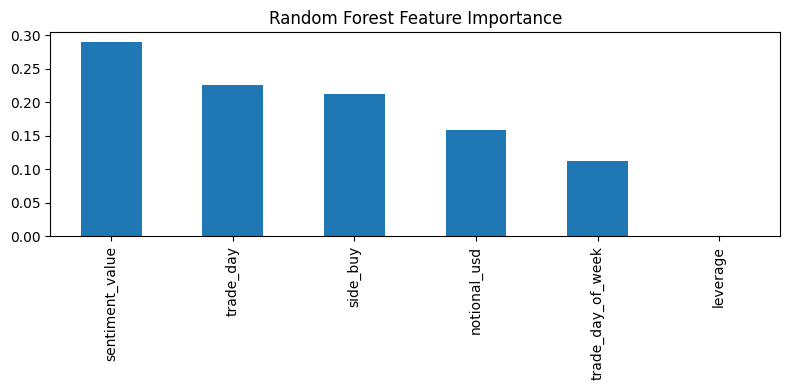

In [299]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1)
rf.fit(X_train.fillna(0), y_train)
y_pred_rf = rf.predict(X_test.fillna(0))
y_proba_rf = rf.predict_proba(X_test.fillna(0))[:,1]

print("Random Forest metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))

# feature importance
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
imp.to_csv(os.path.join(OUT_DIR,'rf_feature_importance.csv'))
print("Saved feature importance")
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
imp.plot(kind='bar')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,'rf_feature_importance.png'), bbox_inches='tight')
plt.show()


In [300]:
import joblib
joblib.dump(rf, os.path.join(OUT_DIR,'rf_model.joblib'))
joblib.dump(scaler, os.path.join(OUT_DIR,'scaler.joblib'))
print("Saved model + scaler")


Saved model + scaler


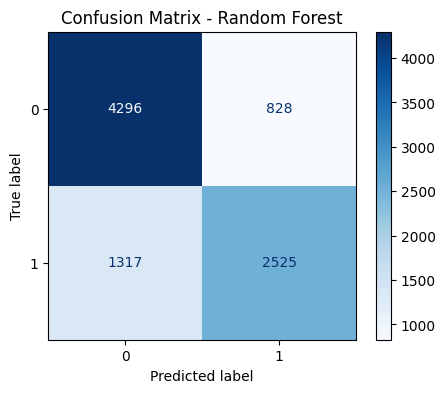

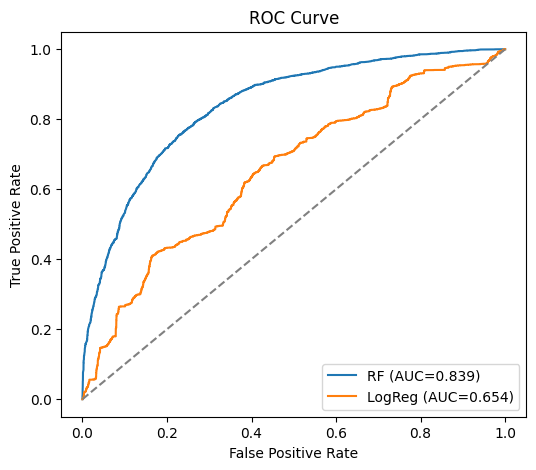

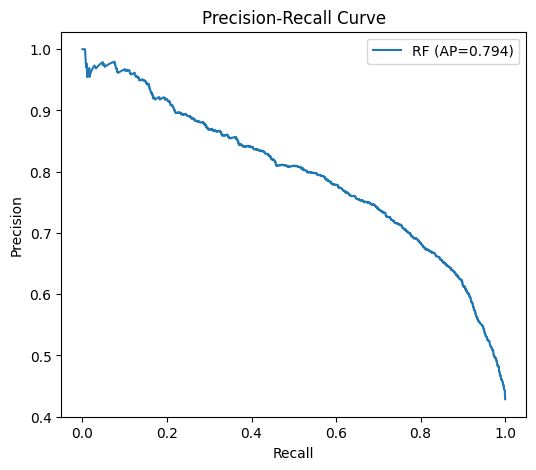

In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score)



# Confusion matrix (Random Forest)
y_pred_rf = rf.predict(X_test.fillna(0))
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(5,4))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix - Random Forest')
plt.savefig(os.path.join(OUT_DIR,'cm_rf.png'), bbox_inches='tight')
plt.show()

# ROC curve (Random Forest)
y_proba_rf = rf.predict_proba(X_test.fillna(0))[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'RF (AUC={roc_auc:.3f})')
# logistic
if 'log' in globals():
    y_proba_log = log.predict_proba(X_test_scaled)[:,1]
    fpr2, tpr2, _ = roc_curve(y_test, y_proba_log)
    roc_auc2 = auc(fpr2,tpr2)
    plt.plot(fpr2, tpr2, label=f'LogReg (AUC={roc_auc2:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig(os.path.join(OUT_DIR,'roc_curve.png'), bbox_inches='tight')
plt.show()

# Precision-Recall curve & AP
plt.figure(figsize=(6,5))
precision, recall, _ = precision_recall_curve(y_test, y_proba_rf)
ap = average_precision_score(y_test, y_proba_rf)
plt.plot(recall, precision, label=f'RF (AP={ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig(os.path.join(OUT_DIR,'pr_curve_rf.png'), bbox_inches='tight')
plt.show()


In [302]:
# Random Forest importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top RF features:\n", importances.head(10))
importances.to_csv(os.path.join(OUT_DIR,'rf_feature_importances_print.csv'))

# Logistic regression coefficients
if 'log' in globals():
    try:
        coefs = pd.Series(log.coef_[0], index=X.columns).sort_values(ascending=False)
        print("\nLogistic regression coefficients:\n", coefs)
        coefs.to_csv(os.path.join(OUT_DIR,'logistic_coefficients.csv'))
    except Exception as e:
        print("Logistic model or coefficients not available:", e)


Top RF features:
 sentiment_value      0.290198
trade_day            0.225355
side_buy             0.212123
notional_usd         0.159268
trade_day_of_week    0.113056
leverage             0.000000
dtype: float64

Logistic regression coefficients:
 sentiment_value      0.161789
trade_day            0.089049
leverage             0.000000
notional_usd        -0.004941
trade_day_of_week   -0.086298
side_buy            -0.468882
dtype: float64


In [303]:
import joblib
model = joblib.load(os.path.join(OUT_DIR,'rf_model.joblib'))
scaler = joblib.load(os.path.join(OUT_DIR,'scaler.joblib'))


sample = pd.DataFrame([{
    'sentiment_value': 65.0,
    'notional_usd': 5000,
    'side_buy': 1,
    'trade_day_of_week': 2,
    'trade_day': 12,
    'leverage': 1
}])

pred_proba = model.predict_proba(sample.fillna(0))[:,1]
pred_class = model.predict(sample.fillna(0))
print("Pred prob:", pred_proba, "pred class:", pred_class)


Pred prob: [0.19778176] pred class: [0]


In [304]:
import os

BASE_DIR = "/content"
CLEAN_DIR = os.path.join(BASE_DIR, "clean")
OUT_DIR = os.path.join(BASE_DIR, "out")

print("Clean dir:", CLEAN_DIR)
print("Out dir:", OUT_DIR)


Clean dir: /content/clean
Out dir: /content/out


In [305]:
!find /content -name "cleaned_data.csv"
